# **UNet++**

A Pytorch implementation of UNet++: A Nested U-Net Architecture for Medical Image Segmentation
  
**Dataset:** CelebAMask

**Reference:**  
https://wsshin.tistory.com/2

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.utils as utils
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random
import itertools

## Hyperparameters

In [ ]:
img_size = 128

batch_size = 12
valid_batch_size = 50
epochs = 100
n_print = 100
lr = 3e-4

workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "/content/drive/MyDrive/Colab Notebooks/NestedUNet"

Device: cuda:0


## Dataset

In [ ]:
# Download custom dataset from kaggle
import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
  print("Already kaggle.json exsits.")
else:
  !mkdir -p ~/.kaggle
  !cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kimjiyeop/celeba-128-onlybg
if os.path.isdir('./CelebA-img'):
  print("Already unzip.")
else:
  !unzip -q celeba-128-onlybg.zip
  print("Unzip Complete!")

 91% 322M/353M [00:02<00:00, 135MB/s]
100% 353M/353M [00:02<00:00, 138MB/s]
Unzip Complete!


In [ ]:
class CelebAwithMask(torch.utils.data.Dataset):
  def __init__(self, split, transform=None):
    rng = {'train':(0,27000), 'valid':(27000,29500), 'test':(29500,30000)}
    s, e = rng[split]
    self.nums = [i for i in range(s, e)]
    self.transform = transform
        
  def __getitem__(self, index):
    num = self.nums[index]
    transform = transforms.Compose([transforms.ToTensor()])

    img = cv2.imread('./CelebA-img/{}.jpg'.format(num))
    if self.transform:
      img = self.transform(img)

    mask = cv2.imread('./CelebA-mask/{}.jpg'.format(num), cv2.IMREAD_GRAYSCALE)
    mask = transform(mask).squeeze(0)

    return img, mask

  def __len__(self):
    return len(self.nums)

# Restore images to suitable images of opencv style
def ImgForPlot(img):
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
dataset = CelebAwithMask(split='train', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

valid_dataset = CelebAwithMask(split='valid', transform=transform)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True, num_workers=workers)

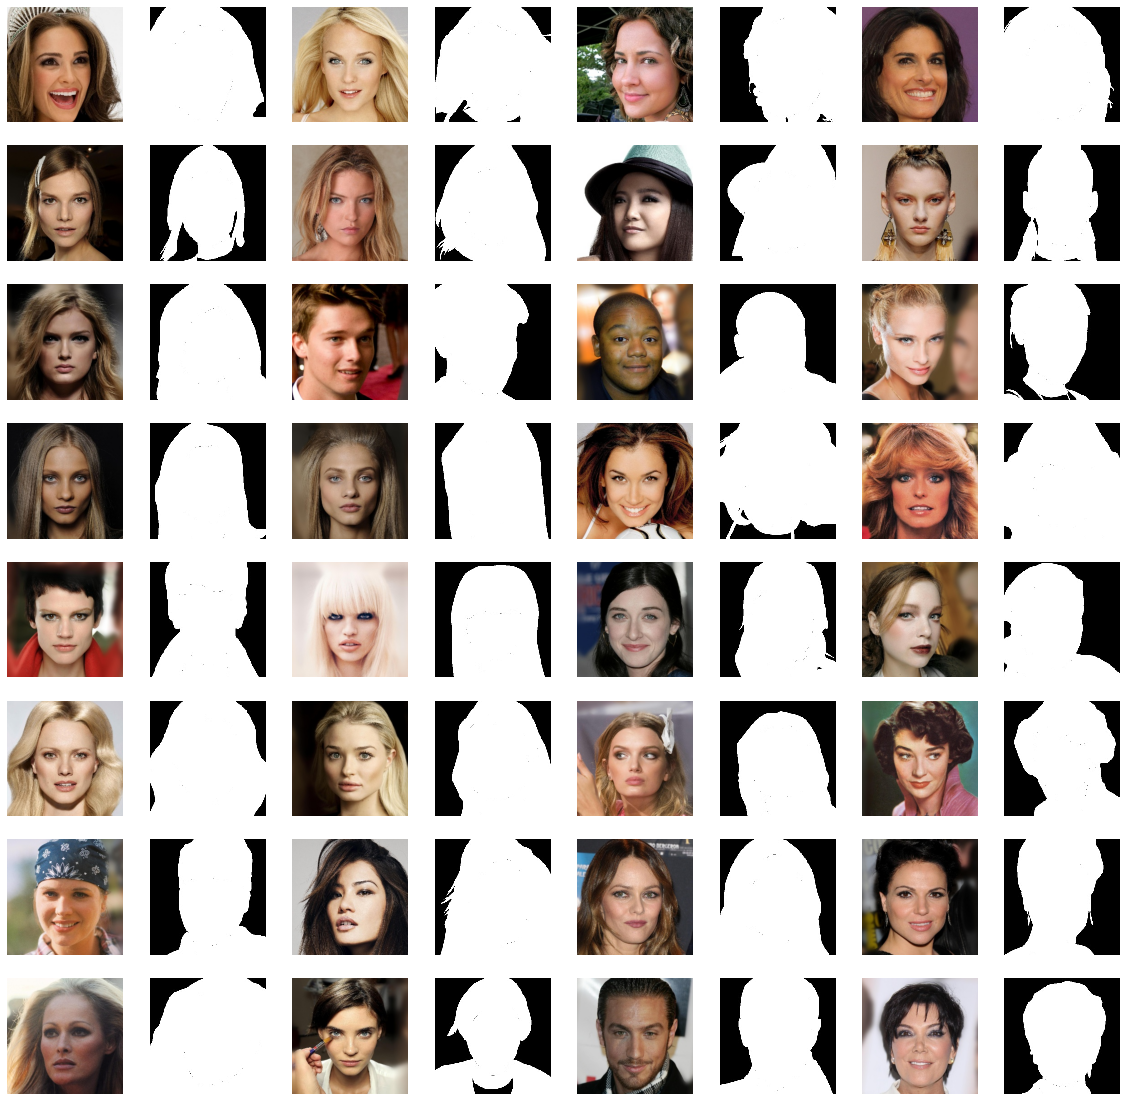

In [ ]:
fig = plt.figure(figsize=(20,20))

for k in range(32):
    img, mask = dataset[k]
    ax = fig.add_subplot(8, 8, 2*k+1)
    ax.imshow(ImgForPlot(img))
    ax.axis("off")
    ax = fig.add_subplot(8, 8, 2*k+2)
    ax.imshow(mask, cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.axis("off")

plt.show()

## Model

In [ ]:
def init_weight(layer):
  nn.init.kaiming_uniform_(layer.weight)
  if layer.bias is not None:
      nn.init.constant_(layer.bias, 0)

### ConvBlock
(Conv + BN + ReLU) x2

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(ConvBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.conv2 = nn.Conv2d(out_channel, out_channel, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU(inplace = True)
    
    init_weight(self.conv1)
    init_weight(self.conv2)

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    return self.relu(self.bn2(self.conv2(x)))

### UNet++

In [ ]:
class UNetPP(nn.Module):
  def __init__(self, in_channel, out_channel):
    super(UNetPP, self).__init__()
    f = [32, 64, 128, 256, 512]

    self.conv0 = nn.ModuleList([ConvBlock(in_channel, f[0])])
    self.conv1 = nn.ModuleList()
    self.conv2 = nn.ModuleList()
    self.conv3 = nn.ModuleList()
    self.conv4 = ConvBlock(f[0]*4 + f[1], f[0])

    for i in range(4):
      self.conv0.append(ConvBlock(f[i], f[i+1]))
      self.conv1.append(ConvBlock(f[i] + f[i+1], f[i]))
      if i < 3: self.conv2.append(ConvBlock(f[i]*2 + f[i+1], f[i]))
      if i < 2: self.conv3.append(ConvBlock(f[i]*3 + f[i+1], f[i]))

    self.convout = nn.ModuleList()
    for i in range(4):
      self.convout.append(nn.Conv2d(f[0], out_channel, 1))
      init_weight(self.convout[i])

    self.down = nn.MaxPool2d(2, stride=2)
    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
  
  def forward(self, x):
    out0 = [self.conv0[0](x)]
    out1, out2, out3 = [], [], []

    for i in range(1, 5):
      out0.append(self.conv0[i](self.down(out0[-1])))

    for i in range(4):
      out1.append(self.conv1[i](torch.cat((out0[i], self.up(out0[i+1])), dim=1)))

    for i in range(3):
      out2.append(self.conv2[i](torch.cat((out0[i], out1[i], self.up(out1[i+1])), dim=1)))

    for i in range(2):
      out3.append(self.conv3[i](torch.cat((out0[i], out1[i], out2[i], self.up(out2[i+1])), dim=1)))
    
    out4 = self.conv4(torch.cat((out0[0], out1[0], out2[0], out3[0], self.up(out3[1])), dim=1))
    y = [out1[0], out2[0], out3[0], out4]
    y = [self.convout[i](y[i]) for i in range(4)]
    return sum(y)/4

## Training

In [ ]:
model = UNetPP(3, 1).cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

### (Option) Load Model

In [ ]:
model_name = 'unet++-celebamask'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"

with open(loss_path, 'rb') as f:
  losses = pickle.load(f)

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### Loss & Metric
Binary Cross Entrophy + Dice coefficient loss

In [ ]:
class IoU(nn.Module):
  def __init__(self, eps=1e-6):
    super(IoU, self).__init__()
    self.eps = eps

  def forward(self, x, y):
    x = torch.sigmoid(x)
    x = x.view(x.size(0), -1)
    y = y.view(y.size(0), -1)
    intersect = torch.sum(x*y, dim=1)
    iou = (intersect + self.eps) / (torch.sum(x, dim=1) + torch.sum(y, dim=1) - intersect + self.eps)
    return torch.mean(iou)

class DiceLoss(nn.Module):
  def __init__(self, eps=1e-6):
    super(DiceLoss, self).__init__()
    self.eps = eps

  def forward(self, x, y):
    x = torch.sigmoid(x)
    x = x.view(x.size(0), -1)
    y = y.view(y.size(0), -1)
    dice = (2 * torch.sum(x*y, dim=1) + self.eps) / (torch.sum(x, dim=1) + torch.sum(y, dim=1) + self.eps)
    return 1 - torch.mean(dice)

class BCEDiceLoss(nn.Module):
  def __init__(self, eps=1e-6):
    super(BCEDiceLoss, self).__init__()
    self.Dice = DiceLoss(eps)

  def forward(self, x, y):
    dice = self.Dice(x, y)
    bce = F.binary_cross_entropy_with_logits(x, y)
    return dice + 0.5 * bce

### Training Model

In [ ]:
model_name = 'unet++-celebamask'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
best_model_path = F"{model_saved_dir}/{model_name}_best.pt"
model_path = F"{model_saved_dir}/{model_name}.pt"

start_epoch = 0

if start_epoch == 0:
  losses = {'train_loss': [], 'train_iou': [], 'valid': []}
  best_loss = 0.
else:
  best_loss = max(losses['valid'])

TrainLoss = BCEDiceLoss()           # Train
MAE = nn.L1Loss(reduction='mean')   # Validation
IOU = IoU()

for ep in range(start_epoch, epochs):
  # Train
  model.train()
  step, loss_sum, iou_sum = 0, 0., 0.
  for batch_idx, (input, target) in enumerate(dataloader, 0):
    step += 1
    input = input.cuda()
    target = target.cuda()
    
    optimizer.zero_grad()
    out = model(input).squeeze(1)
    loss = TrainLoss(out, target)
    loss.backward()
    optimizer.step()

    loss_sum += loss.item()
    losses['train_loss'].append(loss.item())
    
    iou = IOU(out, target).item()
    iou_sum += iou
    losses['train_iou'].append(iou)

    if batch_idx % n_print == (n_print-1) or batch_idx == (len(dataloader)-1):
      print('[%2d/%2d][%4d/%4d] Train: %.4f (IoU: %.4f)' % (ep+1, epochs, batch_idx+1, len(dataloader), loss_sum/step, iou_sum/step))
      step, loss_sum, iou_sum = 0, 0., 0.

  # Validation
  model.eval()
  step, loss_sum, mae_sum = 0, 0., 0.
  for input, target in valid_dataloader:
    with torch.no_grad():
      input = input.cuda()
      target = target.cuda()

      out = model(input).squeeze(1)
      loss = IOU(out, target)
      
      step += input.size(0)
      loss_sum += loss.item() * input.size(0)
      mae_sum += MAE(torch.sigmoid(out), target).item() * input.size(0)

  val_loss = loss_sum / step
  losses['valid'].append(val_loss)

  if val_loss > best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), best_model_path)

  print('[%2d/%2d] Valid: %.4f (Best: %.4f) / MAE: %.4f' % (ep+1, epochs, val_loss, best_loss, mae_sum/step))

  torch.save(model.state_dict(), model_path)
  with open(loss_path, 'wb') as f:
      pickle.dump(losses, f)
  
  print("Saved model completely!")

In [ ]:
loss_per_epoch, iou_per_epoch = [], []

for ep in range(epochs):
  N = len(dataloader)
  loss_per_epoch.append(sum(losses['train_loss'][(ep*N):((ep+1)*N)])/N)
  iou_per_epoch.append(sum(losses['train_iou'][(ep*N):((ep+1)*N)])/N)

min_train = min(loss_per_epoch)
min_train_idx = loss_per_epoch.index(min_train)
print("Train: %.4f at Epoch %d" % (min_train, min_train_idx+1))

max_train = max(iou_per_epoch)
max_train_idx = iou_per_epoch.index(max_train)
print("Train: %.4f at Epoch %d" % (max_train, max_train_idx+1))

max_val = max(losses['valid'])
max_val_idx = losses['valid'].index(max_val)
print("Valid: %.4f at Epoch %d" % (max_val, max_val_idx+1))

Train: 0.0146 at Epoch 100
Train: 0.9892 at Epoch 100
Valid: 0.9616 at Epoch 93


## Loss

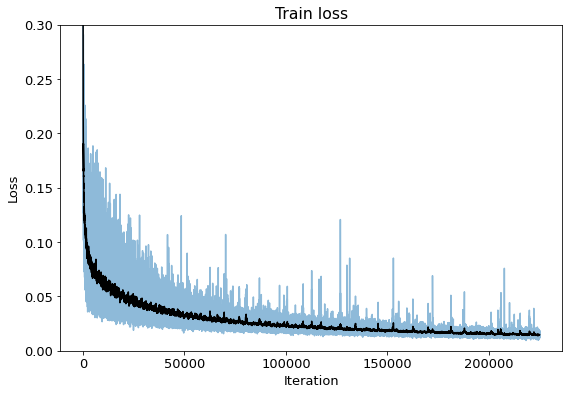

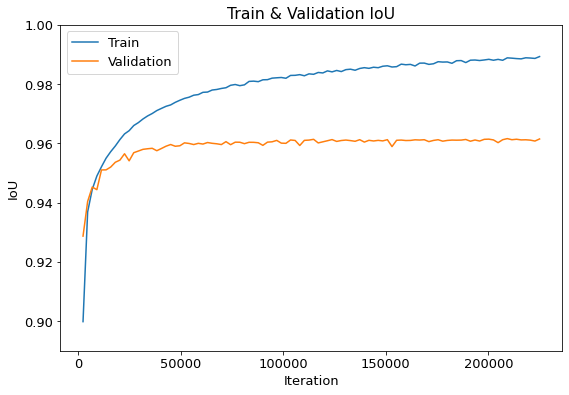

In [ ]:
import matplotlib

matplotlib.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(9,6))

N = len(losses['train_loss'])
T = len(dataloader)
K = 30
avg_loss, avg_iou = [], []
for i in range(K, N-K):
  avg_loss.append(sum(losses['train_loss'][(i-K):(i+K+1)])/(2*K+1))

plt.plot(range(N), losses['train_loss'], alpha=0.5)
plt.plot(range(K, N-K), avg_loss, 'k')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train loss')
plt.ylim(0, 0.3)
plt.savefig('loss.png')

fig = plt.figure(figsize=(9,6))
T = len(dataloader)
plt.plot(range(T-1, N, T), iou_per_epoch, label='Train')
plt.plot(range(T-1, N, T), losses['valid'], label='Validation')
plt.xlabel('Iteration')
plt.ylabel('IoU')
plt.title('Train & Validation IoU')
plt.ylim(0.89, 1)
plt.legend(loc='upper left')
plt.savefig('iou.png')

## Test

In [ ]:
test_dataset = CelebAwithMask(split='test', transform=transform)

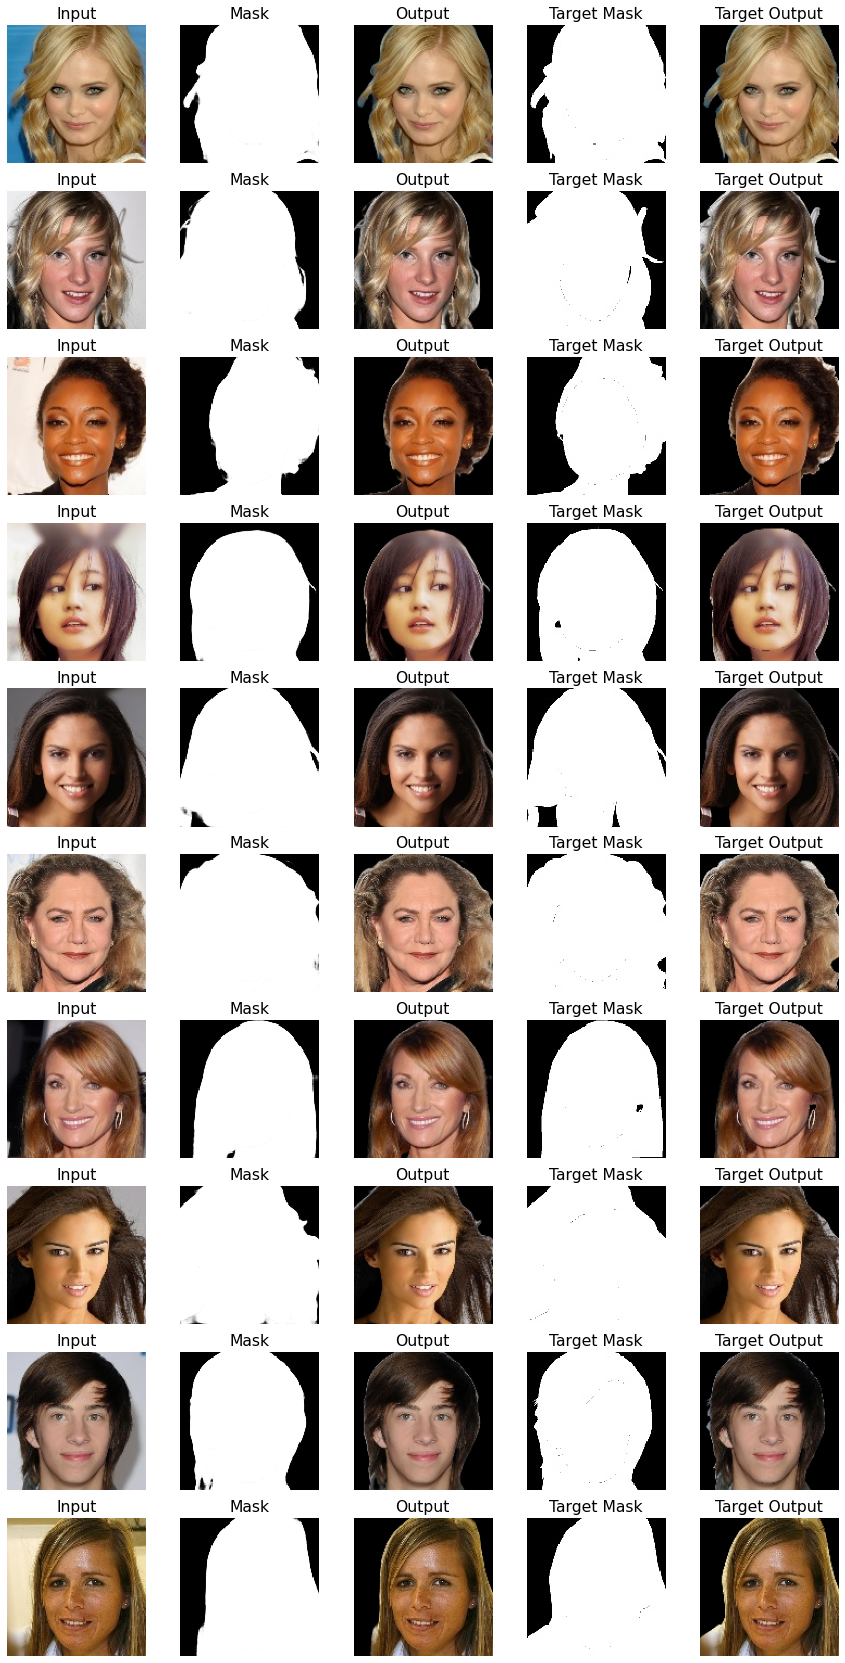

In [ ]:
def maskedImage(img, mask):
  img = img.cpu()
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  mask = mask.unsqueeze(2).detach().cpu().numpy()
  return cv2.cvtColor((img * mask).astype(np.uint8), cv2.COLOR_BGR2RGB)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=workers)

input, target = next(iter(test_dataloader))
input = input.cuda()
target = target.cuda()
mask = torch.sigmoid(model(input).squeeze(1))

fig = plt.figure(figsize=(15, 30))
for k in range(10):
    ax = fig.add_subplot(10, 5, 5*k+1)
    ax.imshow(ImgForPlot(input[k].cpu()))
    ax.set_title('Input')
    ax.axis("off")

    ax = fig.add_subplot(10, 5, 5*k+2)
    ax.imshow(mask[k].detach().cpu(), cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.set_title('Mask')
    ax.axis("off")

    ax = fig.add_subplot(10, 5, 5*k+3)
    ax.imshow(maskedImage(input[k], mask[k]))
    ax.set_title('Output')
    ax.axis("off")

    ax = fig.add_subplot(10, 5, 5*k+4)
    ax.imshow(target[k].detach().cpu(), cmap='gray', vmin=0, vmax=1, interpolation='none')
    ax.set_title('Target Mask')
    ax.axis("off")
    
    ax = fig.add_subplot(10, 5, 5*k+5)
    ax.imshow(maskedImage(input[k], target[k]))
    ax.set_title('Target Output')
    ax.axis("off")

plt.savefig('result.png')

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=workers)

MAE = nn.L1Loss(reduction='mean')
IOU = IoU()
n_test, test_mae, test_iou = 0, 0., 0.

model.eval()
with torch.no_grad():
  for input, target in test_dataloader:
    out = model(input.cuda()).squeeze(1)
    test_mae += MAE(torch.sigmoid(out), target.cuda()).item()
    test_iou += IOU(out, target.cuda()).item()
    n_test += input.size(0)

print('# of Images: %d' % n_test)
print("Test MAE: %.6f" % (test_mae / len(test_dataloader)))
print("Test IOU: %.6f" % (test_iou / len(test_dataloader)))

# of Images: 500
Test MAE: 0.026910
Test IOU: 0.961839


## Synthesize GIF

In [ ]:
import cv2

def GifToFrame(path, crop=None, transform=None): 
    frames, masks = [], []
    gif = cv2.VideoCapture(gif_path)
    fps = gif.get(cv2.CAP_PROP_FPS)
    
    while True:
        ret, frame = gif.read()
        if ret:
            if crop:
                x1, x2, y1, y2 = crop
                frame = frame[y1:y2,x1:x2]
                
            if transform:
                frames.append(transform(frame))
            else:
                frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            
        else:
            break
            
    flag = 1 if transform else 0
    
    print("GIF Info: %dx%d, %d frames, %d fps" % 
          (frames[0].shape[flag], frames[0].shape[1+flag], len(frames), fps))
    
    return frames, fps

GIF Info: 128x128, 86 frames, 12 fps


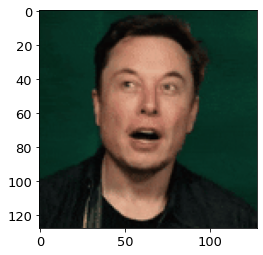

Save generated gif completely.
Save combined gif completely.
GIF Info: 128x128, 37 frames, 20 fps


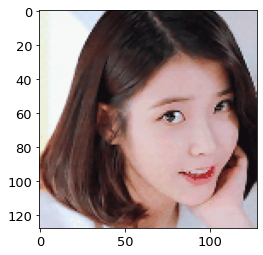

Save generated gif completely.
Save combined gif completely.


In [ ]:
import imageio

paths = ["elon.gif", "iu.gif"]

for gif_path in paths:
  resize, fps = GifToFrame(gif_path, transform=transform)
  plt.imshow(ImgForPlot(resize[0]))
  plt.show()

  # Change frames with generator
  inputs = torch.stack(resize).cuda()

  with torch.no_grad():
    outputs = torch.sigmoid(model(inputs).squeeze(1))

  # Save Generated GIF
  outputs = [maskedImage(inputs[k], outputs[k]) for k in range(len(outputs))]
  gen_path = gif_path.replace(".gif","-generated.gif")
  imageio.mimsave(gen_path, outputs, format='GIF', fps=fps)
  print("Save generated gif completely.")

  combs = []
  for i in range(len(outputs)):
      comb = np.ndarray((128,256,3), dtype=np.uint8)
      comb[:, 0:128] = ImgForPlot(resize[i])
      comb[:, 128:256] = outputs[i]
      combs.append(comb)

  comb_path = gif_path.replace(".gif","-combined.gif")
  imageio.mimsave(comb_path, combs, format='GIF', fps=fps)
  print("Save combined gif completely.")